In [1]:
from scipy.stats import loguniform
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, Normalizer, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# disable warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
scaler = MaxAbsScaler()

In [3]:
data = pd.read_csv(
    "<masked out>",
    index_col=0,
    dtype={
        "gmail_alias": str,
        "usrname": str,
        "domain": str,
        "subject": str,
        "body": str,
        "num_ccs": int,
        "num_urls": int,
        "num_attachments": int,
        "label": int
    },
    na_filter=False
)

In [ ]:
data.head()

In [5]:
train_df, test_df = train_test_split(data, stratify=data["label"], test_size=0.2)

In [6]:
train_neg, train_pos = np.bincount(train_df["label"])
test_neg, test_pos = np.bincount(test_df["label"])
print("training pos={:.2f}%, test pos={:.2f}%".format((100*train_pos/(train_pos + train_neg)), (100*test_pos/(test_pos + test_neg))))

training pos=18.31%, test pos=18.36%


In [7]:
# let's build a column transformer
# the first 3 features are already numerical, so can passthrough
# next 3 features are already tokenized, so we probably just need tf-idf transformer
# next 2 features need to be first countvectorized and then tf-idf

dummy_vectorizer = CountVectorizer(analyzer=lambda d:(d,), min_df=2)

In [8]:
print(dummy_vectorizer.fit_transform(["Google Takeout", "Bye Bye", "Google Takeout"]))

  (0, 0)	1
  (2, 0)	1


In [9]:
print(dummy_vectorizer.get_feature_names())

['Google Takeout']


In [10]:
sender_transformer = TfidfVectorizer(lowercase=False, analyzer=lambda doc:(doc,))
text_transformer = TfidfVectorizer(lowercase=False, analyzer=lambda doc: doc.split())

column_transformer = ColumnTransformer(
    transformers=[
        ("sender_alias", sender_transformer, 0),
        ("sender_usr", sender_transformer, 1),
        ("sender_domain", sender_transformer, 2),
        ("subject", text_transformer, 3),
        ("body", text_transformer, 4),
    ],
    remainder="passthrough"
)

preprocessor = Pipeline(
[
    ("column_transformer", column_transformer),
    ("scaler", scaler)
])

In [11]:
y_train = np.array(train_df.pop("label"))
X_train = np.array(train_df)
y_test = np.array(test_df.pop("label"))
X_test = np.array(test_df)

In [12]:
X_train.shape

(3069, 8)

In [13]:
# test the preprocessor
preprocessor.fit_transform(X_train).shape

(3069, 29113)

In [ ]:
"""
First, what are the models we can choose from?
    - Non Parametric
        - KNN [x]
    - Linear
        - Logistic Regression [x]
        - Naive Bayes [x]
        - LDA (Like Naive Bayes but assumes each p(x|y) follows a normal distribution. Does not have i.i.d assumption) [x]
        - QDA (Like LDA but does not assume k classes share same covariance matrix) [x]
    - Non Linear
        - SVM [x]
        - High-Order Functions, Splines, and GAMs []
        - Tree []
        
Second, what are the available feature selection methods for each model?
    - Applicable to Linear:
        - PCA to reduce dimension (in our case features are not quite interpretable. We can try this)
            - With PCA, each principle component is uncorrelated with every other component
        - Partial Least Square (usually works pretty much the same as PCA in practice)
        - Ridge
        - Lasso

Third, what are the hyperparameters of each model?
    - KNN
        - n_neighbors (int)
        - weights ("uniform" or "distance")
    - Logistic Regression
        - penalty ("l1", "l2", "elasticnet")
        - C (inverse of regularization strength > 0)
        - fit_intercept [True, False]
        - class_weight
        - max_iter
        - warm_start
        use liblinear/saga to first select features (if we don't do PCR)
        for liblinear:
            - dual [True, False]
            - intercept_scaling

Finally, what are the hyperparameter tuning method we can use for each model?
"""

In [14]:
# utility functions
def create_pivot_table(search_result):
    results = pd.DataFrame(search_result.cv_results_)
    results = results.assign(
        params_str=lambda x: x.params.apply(str)
    )
    results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
    return results.pivot(
        index="iter", columns="params_str", values="mean_test_score"
    )

def plot_search_results(search_result):
    pivot_table = create_pivot_table(search_result)
    ax = pivot_table.plot(legend=False, alpha=0.6)

    labels = [
        f"iter={i}\nn_samples={search_result.n_resources_[i]}\nn_candidates={search_result.n_candidates_[i]}"
        for i in range(search_result.n_iterations_)
    ]

    ax.set_xticks(range(search_result.n_iterations_))
    ax.set_xticklabels(labels, rotation=45, multialignment="left")
    ax.set_title("Scores of candidates over iterations")
    ax.set_ylabel("mean test score", fontsize=15)
    ax.set_xlabel("iterations", fontsize=15)
    plt.tight_layout()
    plt.show()

In [15]:
"""
Let's start with KNN
Preprocessings needed:
1. scale the predictors to same unit
2. PCA to reduce dimensionality
3. normalize samples
"""

knn_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("pca", TruncatedSVD(random_state=4321)),
    ("normalizer", Normalizer()),
    ("clf", KNeighborsClassifier())
]
)

param_grid = {
    "pca__n_components": np.logspace(0, 8, num=6, base=2, dtype=int),
    "clf__n_neighbors": np.logspace(0, 6, num=6, base=2, dtype=int),
    "clf__weights": ["uniform", "distance"]
}

search = HalvingRandomSearchCV(
    knn_pipeline, param_distributions=param_grid, min_resources=375, factor=2, scoring=make_scorer(f1_score), random_state=1234
)

fitted = search.fit(X_train, y_train)

In [16]:
create_pivot_table(search)

params_str,"{'pca__n_components': 1, 'clf__weights': 'distance', 'clf__n_neighbors': 1}","{'pca__n_components': 256, 'clf__weights': 'distance', 'clf__n_neighbors': 27}","{'pca__n_components': 256, 'clf__weights': 'uniform', 'clf__n_neighbors': 5}","{'pca__n_components': 27, 'clf__weights': 'distance', 'clf__n_neighbors': 12}","{'pca__n_components': 27, 'clf__weights': 'uniform', 'clf__n_neighbors': 27}","{'pca__n_components': 27, 'clf__weights': 'uniform', 'clf__n_neighbors': 5}","{'pca__n_components': 84, 'clf__weights': 'distance', 'clf__n_neighbors': 12}","{'pca__n_components': 9, 'clf__weights': 'uniform', 'clf__n_neighbors': 64}"
iter,,,,,,,,
0,0.062921,0.252235,0.548284,0.429773,0.387922,0.398570,0.494046,0.0
1,NaN,NaN,0.498706,0.462585,NaN,0.504829,0.559131,NaN
2,NaN,NaN,NaN,NaN,NaN,0.581476,0.672886,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.745519,NaN


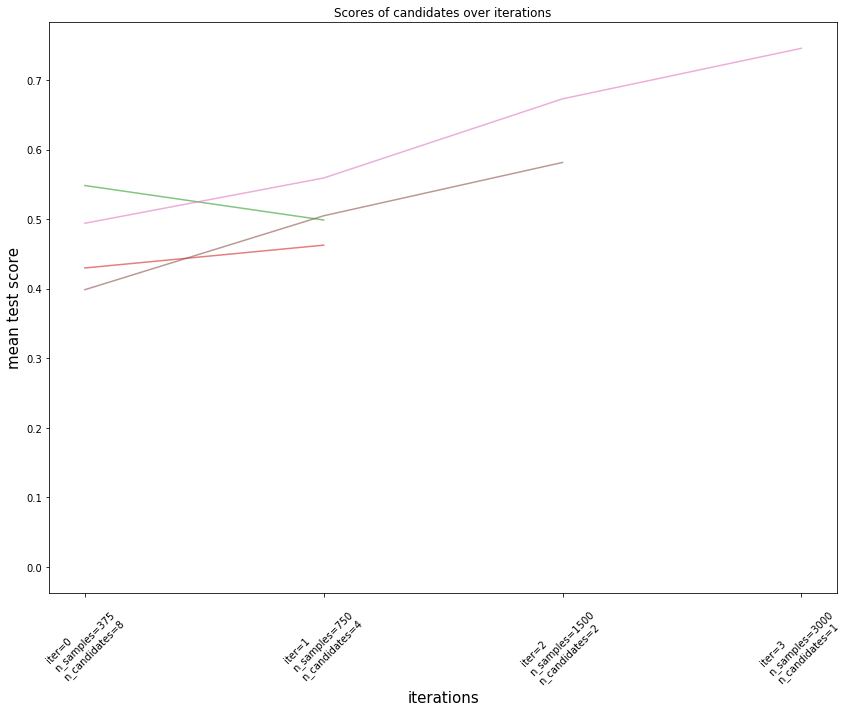

In [17]:
plot_search_results(search)

In [21]:
"""
First, let's try logistic regression without PCA
we'll first use liblinear solver to select features
that we will actually use to do the logistic regression on
preproccessing:
1. scale the predictors to same unit
"""
feature_selection_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(penalty="l1", solver="liblinear", random_state=4321))
]
)

param_grid = {
    "clf__C": loguniform(1e-4, 1e1),
    "clf__fit_intercept": [False, True],
    "clf__intercept_scaling": loguniform(1e-4, 1e1),
    "clf__class_weight": [None, "balanced"],
    "clf__max_iter": loguniform(1e1, 1e3),
    "clf__warm_start": [False, True]
}

feature_search = HalvingRandomSearchCV(
    feature_selection_pipeline, param_distributions=param_grid, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)

fitted = feature_search.fit(X_train, y_train)

In [22]:
create_pivot_table(feature_search)

params_str,"{'clf__C': 0.0009069790423538588, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.015439694222291704, 'clf__max_iter': 372.1492665736836, 'clf__warm_start': True}","{'clf__C': 0.7313632065748891, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.0066746718556441025, 'clf__max_iter': 170.1344873728303, 'clf__warm_start': True}","{'clf__C': 0.8783158391722696, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.06926171853268971, 'clf__max_iter': 547.3369642905609, 'clf__warm_start': False}","{'clf__C': 1.0308556263012236, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.00019053170105481985, 'clf__max_iter': 76.79364784885479, 'clf__warm_start': True}","{'clf__C': 2.010707310312529, 'clf__class_weight': 'balanced', 'clf__fit_intercept': False, 'clf__intercept_scaling': 0.0009830911695227402, 'clf__max_iter': 426.8997181796593, 'clf__warm_start': False}","{'clf__C': 2.3969731745855443, 'clf__class_weight': None, 'clf__fit_intercept': False, 'clf__intercept_scaling': 0.03198715594382152, 'clf__max_iter': 232.76939100527687, 'clf__warm_start': True}","{'clf__C': 7.019319313442753, 'clf__class_weight': 'balanced', 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.055029790939223, 'clf__max_iter': 84.16920135371561, 'clf__warm_start': True}","{'clf__C': 8.623757016338889, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.009309187152358643, 'clf__max_iter': 80.43769526753181, 'clf__warm_start': True}"
iter,,,,,,,,
0,0.0,0.449883,0.452172,0.517474,0.551299,0.548909,0.584590,0.574461
1,NaN,NaN,NaN,NaN,0.655832,0.672633,0.675173,0.660399
2,NaN,NaN,NaN,NaN,NaN,0.701938,0.728824,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.763156,NaN


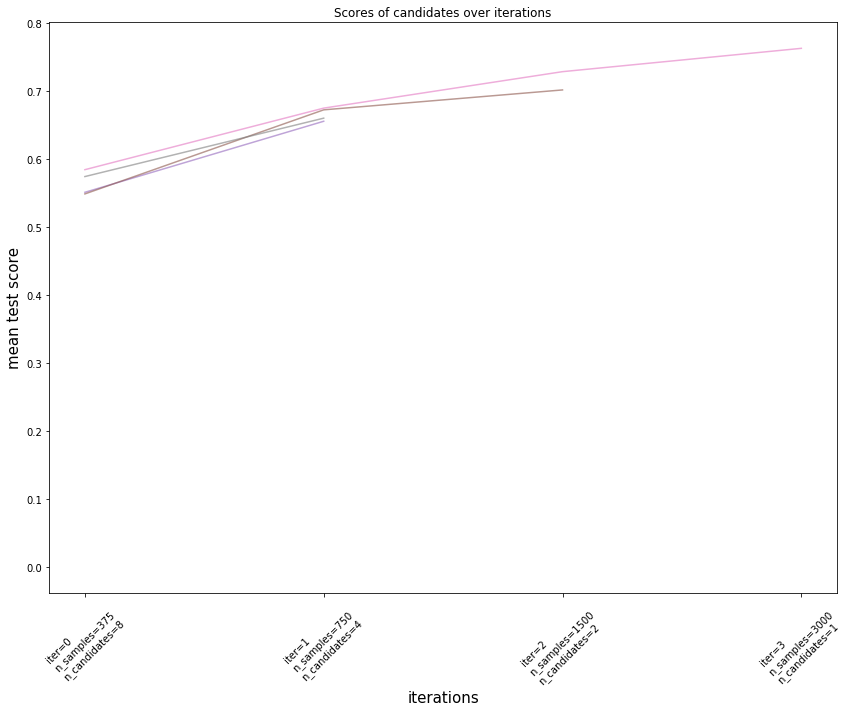

In [23]:
plot_search_results(feature_search)

In [24]:
"""
now that we've got the best set of features using cross validation,
get the best estimator out and put into another pipeline
"""
lrc_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("fs", SelectFromModel(estimator=feature_search.best_estimator_.named_steps["clf"])),
    ("clf", LogisticRegression(penalty="l2", random_state=4001))
])
    
param_grid = {
    "clf__C": loguniform(1e-4, 1e1),
    "clf__dual": [False, True],
    "clf__fit_intercept": [False, True],
    "clf__intercept_scaling": loguniform(1e-4, 1e1),
    "clf__class_weight": [None, "balanced"],
    "clf__max_iter": loguniform(1e1, 1e3),
    "clf__warm_start": [False, True],
    "clf__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

search = HalvingRandomSearchCV(
    lrc_pipeline, param_distributions=param_grid, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)

fitted = search.fit(X_train, y_train)

In [25]:
create_pivot_table(search)

params_str,"{'clf__C': 0.0002381805030702129, 'clf__class_weight': 'balanced', 'clf__dual': False, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.009309187152358643, 'clf__max_iter': 80.43769526753181, 'clf__solver': 'sag', 'clf__warm_start': False}","{'clf__C': 0.0005234004872142782, 'clf__class_weight': None, 'clf__dual': False, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.007627129925862437, 'clf__max_iter': 45.271425362981034, 'clf__solver': 'lbfgs', 'clf__warm_start': False}","{'clf__C': 0.000566480321724948, 'clf__class_weight': None, 'clf__dual': True, 'clf__fit_intercept': False, 'clf__intercept_scaling': 6.175850414870781, 'clf__max_iter': 564.7617424572878, 'clf__solver': 'liblinear', 'clf__warm_start': False}","{'clf__C': 0.0009069790423538588, 'clf__class_weight': None, 'clf__dual': True, 'clf__fit_intercept': False, 'clf__intercept_scaling': 0.11496336663867616, 'clf__max_iter': 348.91515857331575, 'clf__solver': 'lbfgs', 'clf__warm_start': True}","{'clf__C': 0.016342302487291425, 'clf__class_weight': 'balanced', 'clf__dual': False, 'clf__fit_intercept': False, 'clf__intercept_scaling': 2.5894406007834796, 'clf__max_iter': 53.67498945698209, 'clf__solver': 'newton-cg', 'clf__warm_start': True}","{'clf__C': 0.03198715594382152, 'clf__class_weight': 'balanced', 'clf__dual': False, 'clf__fit_intercept': True, 'clf__intercept_scaling': 1.0308556263012236, 'clf__max_iter': 15.721858061410025, 'clf__solver': 'liblinear', 'clf__warm_start': False}","{'clf__C': 0.8976571882477813, 'clf__class_weight': 'balanced', 'clf__dual': True, 'clf__fit_intercept': False, 'clf__intercept_scaling': 2.216342874345608, 'clf__max_iter': 74.53269891023348, 'clf__solver': 'lbfgs', 'clf__warm_start': True}","{'clf__C': 3.520300966430642, 'clf__class_weight': 'balanced', 'clf__dual': False, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.27936900082336075, 'clf__max_iter': 722.922718557452, 'clf__solver': 'newton-cg', 'clf__warm_start': False}"
iter,,,,,,,,
0,0.456362,0.0,0.080769,0.0,0.581160,0.597258,0.0,0.594743
1,0.472983,NaN,NaN,NaN,0.645091,0.644454,NaN,0.668893
2,NaN,NaN,NaN,NaN,0.660540,NaN,NaN,0.731154
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.774722


In [26]:
# inspect how many features were selected
len(search.best_estimator_[:-1].get_feature_names_out())

644

In [27]:
"""
Now that we've tried the original logistic regression, let's see how pcr does
"""
pcr_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("pca", TruncatedSVD(random_state=4321)),
    ("clf", LogisticRegression(penalty="l2", random_state=4001))
]
)

param_grid = {
    "pca__n_components": np.logspace(3, 10, num=8, base=2, dtype=int),
    "clf__C": loguniform(1e-4, 1e1),
    "clf__dual": [False, True],
    "clf__fit_intercept": [False, True],
    "clf__intercept_scaling": loguniform(1e-4, 1e1),
    "clf__class_weight": [None, "balanced"],
    "clf__max_iter": loguniform(1e1, 1e3),
    "clf__warm_start": [False, True],
    "clf__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

pcr_search = HalvingRandomSearchCV(
    pcr_pipeline, param_distributions=param_grid, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)

pcr_fitted = pcr_search.fit(X_train, y_train)

In [28]:
create_pivot_table(pcr_search)

params_str,"{'clf__C': 0.00017249495353998556, 'clf__class_weight': None, 'clf__dual': False, 'clf__fit_intercept': False, 'clf__intercept_scaling': 7.525036674513798, 'clf__max_iter': 62.23059226702994, 'clf__solver': 'lbfgs', 'clf__warm_start': False, 'pca__n_components': 256}","{'clf__C': 0.0009069790423538588, 'clf__class_weight': None, 'clf__dual': True, 'clf__fit_intercept': False, 'clf__intercept_scaling': 0.11496336663867616, 'clf__max_iter': 348.91515857331575, 'clf__solver': 'lbfgs', 'clf__warm_start': True, 'pca__n_components': 16}","{'clf__C': 0.001241539462933197, 'clf__class_weight': 'balanced', 'clf__dual': True, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.1709076954444084, 'clf__max_iter': 12.440933109455317, 'clf__solver': 'newton-cg', 'clf__warm_start': True, 'pca__n_components': 8}","{'clf__C': 0.0024116888511636634, 'clf__class_weight': 'balanced', 'clf__dual': False, 'clf__fit_intercept': False, 'clf__intercept_scaling': 0.0006224102927321103, 'clf__max_iter': 17.07165616739042, 'clf__solver': 'newton-cg', 'clf__warm_start': False, 'pca__n_components': 128}","{'clf__C': 0.261405472864251, 'clf__class_weight': 'balanced', 'clf__dual': True, 'clf__fit_intercept': False, 'clf__intercept_scaling': 0.0003099271893322915, 'clf__max_iter': 12.941567979272525, 'clf__solver': 'sag', 'clf__warm_start': False, 'pca__n_components': 256}","{'clf__C': 0.7313632065748891, 'clf__class_weight': None, 'clf__dual': True, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.49139851540711227, 'clf__max_iter': 600.4160090112997, 'clf__solver': 'newton-cg', 'clf__warm_start': True, 'pca__n_components': 32}","{'clf__C': 2.216342874345608, 'clf__class_weight': None, 'clf__dual': False, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.00015950736614315744, 'clf__max_iter': 124.80705777296944, 'clf__solver': 'saga', 'clf__warm_start': True, 'pca__n_components': 256}","{'clf__C': 4.631274362574301, 'clf__class_weight': 'balanced', 'clf__dual': True, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.0490613141235345, 'clf__max_iter': 381.28015819146134, 'clf__solver': 'sag', 'clf__warm_start': True, 'pca__n_components': 128}"
iter,,,,,,,,
0,0.0,0.0,0.0,0.557452,0.0,0.0,0.470007,0.0
1,0.0,NaN,0.0,0.619688,NaN,NaN,0.514329,NaN
2,NaN,NaN,NaN,0.642769,NaN,NaN,0.642347,NaN
3,NaN,NaN,NaN,0.667577,NaN,NaN,NaN,NaN


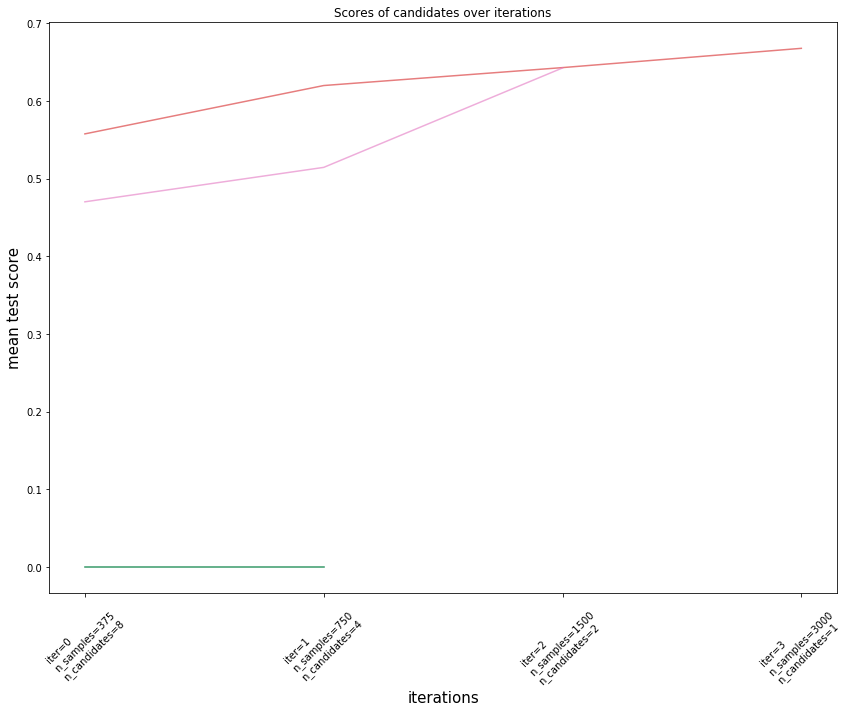

In [29]:
plot_search_results(pcr_search)

In [30]:
# try LDA
lda_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("pca", TruncatedSVD(random_state=4321)),
    ("clf", LinearDiscriminantAnalysis())
]
)

params = {
    "pca__n_components": np.logspace(6, 13, num=8, base=2, dtype=int),
    "clf__solver": ["svd", "lsqr", "eigen"],
    "clf__shrinkage": [None, "auto", *loguniform.rvs(1e-6, 1, size=8).tolist()],
}

lda_search = HalvingRandomSearchCV(
    lda_pipeline, param_distributions=params, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)

lda_fitted = lda_search.fit(X_train, y_train)

In [31]:
create_pivot_table(lda_search)

params_str,"{'pca__n_components': 1024, 'clf__solver': 'svd', 'clf__shrinkage': 5.869826850311116e-05}","{'pca__n_components': 256, 'clf__solver': 'lsqr', 'clf__shrinkage': 0.00020745324782253275}","{'pca__n_components': 256, 'clf__solver': 'lsqr', 'clf__shrinkage': 6.538856775636905e-06}","{'pca__n_components': 4096, 'clf__solver': 'svd', 'clf__shrinkage': None}","{'pca__n_components': 8192, 'clf__solver': 'eigen', 'clf__shrinkage': 0.13820598125429256}","{'pca__n_components': 8192, 'clf__solver': 'eigen', 'clf__shrinkage': 5.869826850311116e-05}","{'pca__n_components': 8192, 'clf__solver': 'lsqr', 'clf__shrinkage': 0.00020745324782253275}","{'pca__n_components': 8192, 'clf__solver': 'svd', 'clf__shrinkage': 'auto'}"
iter,,,,,,,,
0,0.0,0.517166,0.517166,0.000000,0.000000,0.0,0.0,0.0
1,NaN,0.556729,0.556729,0.264383,0.634713,NaN,NaN,NaN
2,NaN,NaN,0.670952,NaN,0.723477,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.782625,NaN,NaN,NaN


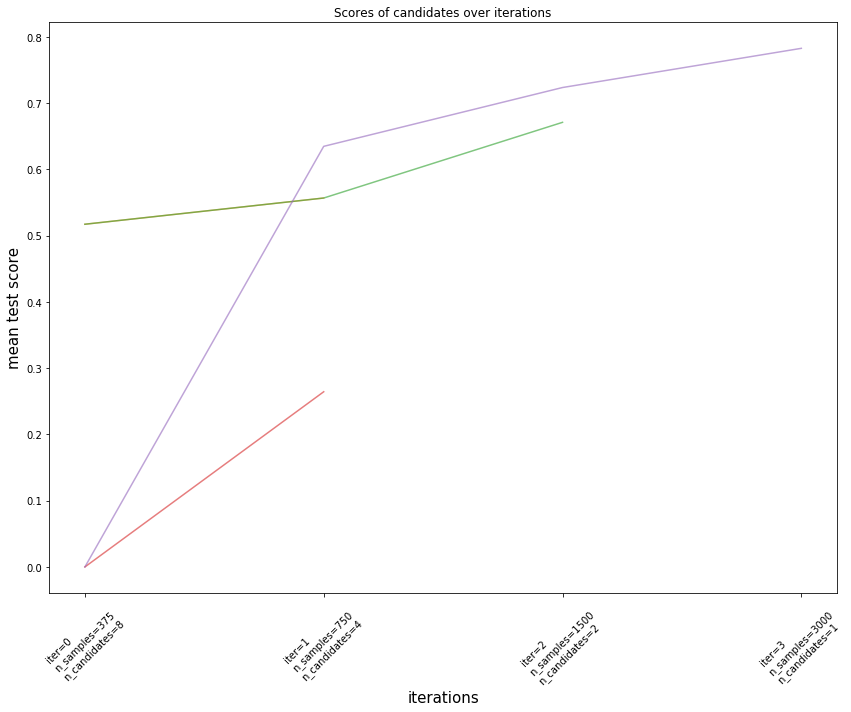

In [32]:
plot_search_results(lda_search)

In [47]:
# try feature-selected LDA
lda_s_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("fs", SelectFromModel(estimator=feature_search.best_estimator_.named_steps["clf"])),
    ("to_dense", FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ("clf", LinearDiscriminantAnalysis())
]
)

params = {
    "clf__solver": ["svd", "lsqr", "eigen"],
    "clf__shrinkage": [None, "auto", *loguniform.rvs(1e-6, 1, size=8).tolist()],
}

lda_s_search = HalvingRandomSearchCV(
    lda_s_pipeline, param_distributions=params, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)

lda_s_fitted = lda_s_search.fit(X_train, y_train)

In [48]:
create_pivot_table(lda_s_search)

params_str,"{'clf__solver': 'eigen', 'clf__shrinkage': 0.00229567309032749}","{'clf__solver': 'eigen', 'clf__shrinkage': 0.014286594480704571}","{'clf__solver': 'lsqr', 'clf__shrinkage': 'auto'}","{'clf__solver': 'lsqr', 'clf__shrinkage': 0.00011990140184612104}","{'clf__solver': 'lsqr', 'clf__shrinkage': 0.014286594480704571}","{'clf__solver': 'lsqr', 'clf__shrinkage': 4.544629241380645e-05}","{'clf__solver': 'lsqr', 'clf__shrinkage': None}","{'clf__solver': 'svd', 'clf__shrinkage': 'auto'}"
iter,,,,,,,,
0,0.577325,0.564996,0.578268,0.577325,0.564996,0.577325,0.577325,0.0
1,0.638462,NaN,0.604334,0.636251,NaN,NaN,0.633080,NaN
2,0.667233,NaN,NaN,0.668395,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.735547,NaN,NaN,NaN,NaN


In [35]:
# try GaussianNB (Naive Bayes)
nb_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("to_dense", FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ("clf", GaussianNB())
]
)

params = {
    "clf__var_smoothing": loguniform(1e-10, 1e1),
}

nb_search = HalvingRandomSearchCV(
    nb_pipeline, param_distributions=params, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)
nb_fitted = nb_search.fit(X_train, y_train)

In [36]:
create_pivot_table(nb_search)

params_str,{'clf__var_smoothing': 0.0006969417498590972},{'clf__var_smoothing': 0.037995650947074626},{'clf__var_smoothing': 0.04354561423066491},{'clf__var_smoothing': 0.06615976484086121},{'clf__var_smoothing': 1.099276152523047e-07},{'clf__var_smoothing': 1.2785389236711619e-08},{'clf__var_smoothing': 6.531382662557254e-06},{'clf__var_smoothing': 9.965948948091088e-08}
iter,,,,,,,,
0,0.399897,0.423538,0.430632,0.414312,0.379805,0.379805,0.379805,0.379805
1,0.424811,0.490723,0.487373,0.492906,NaN,NaN,NaN,NaN
2,NaN,0.549783,NaN,0.571020,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.627073,NaN,NaN,NaN,NaN


In [49]:
# try GaussianNB with selected features
nbs_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("fs", SelectFromModel(estimator=feature_search.best_estimator_.named_steps["clf"])),
    ("to_dense", FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ("clf", GaussianNB())
]
)

params = {
    "clf__var_smoothing": loguniform(1e-10, 1e1),
}

nbs_search = HalvingRandomSearchCV(
    nbs_pipeline, param_distributions=params, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)
nbs_fitted = nbs_search.fit(X_train, y_train)

In [50]:
create_pivot_table(nbs_search)

params_str,{'clf__var_smoothing': 0.0006969417498590972},{'clf__var_smoothing': 0.037995650947074626},{'clf__var_smoothing': 0.04354561423066491},{'clf__var_smoothing': 0.06615976484086121},{'clf__var_smoothing': 1.099276152523047e-07},{'clf__var_smoothing': 1.2785389236711619e-08},{'clf__var_smoothing': 6.531382662557254e-06},{'clf__var_smoothing': 9.965948948091088e-08}
iter,,,,,,,,
0,0.470516,0.458501,0.458501,0.425774,0.463084,0.448289,0.474469,0.468375
1,0.528988,NaN,NaN,NaN,0.495677,NaN,0.495065,0.495677
2,0.649147,NaN,NaN,NaN,NaN,NaN,NaN,0.640260
3,0.667363,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# try GaussianNB with pca
nbp_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("pca", TruncatedSVD(n_components=256, random_state=4321)),
    ("clf", GaussianNB())
]
)

params = {
    "clf__var_smoothing": loguniform(1e-10, 1e1),
}

nbp_search = HalvingRandomSearchCV(
    nbp_pipeline, param_distributions=params, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)
nbp_fitted = nbp_search.fit(X_train, y_train)

In [40]:
create_pivot_table(nbp_search)

params_str,{'clf__var_smoothing': 0.0006969417498590972},{'clf__var_smoothing': 0.037995650947074626},{'clf__var_smoothing': 0.04354561423066491},{'clf__var_smoothing': 0.06615976484086121},{'clf__var_smoothing': 1.099276152523047e-07},{'clf__var_smoothing': 1.2785389236711619e-08},{'clf__var_smoothing': 6.531382662557254e-06},{'clf__var_smoothing': 9.965948948091088e-08}
iter,,,,,,,,
0,0.480938,0.446893,0.446893,0.427793,0.430900,0.4309,0.4309,0.4309
1,0.359570,0.356839,0.338756,NaN,0.357988,NaN,NaN,NaN
2,0.548651,NaN,NaN,NaN,0.547681,NaN,NaN,NaN
3,0.579636,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# try QDA
qda_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("to_dense", FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ("clf", QuadraticDiscriminantAnalysis())
]
)

params = {
    "clf__reg_param": loguniform(1e-9, 1),
}

qda_search = HalvingRandomSearchCV(
    qda_pipeline, param_distributions=params, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)

qda_fitted = qda_search.fit(X_train, y_train)

In [42]:
create_pivot_table(qda_search)

params_str,{'clf__reg_param': 0.00039717228856155675},{'clf__reg_param': 0.010466037176541178},{'clf__reg_param': 0.011701115155104866},{'clf__reg_param': 0.016475917089206638},{'clf__reg_param': 2.840098794801195e-07},{'clf__reg_param': 3.0773599420973997e-07},{'clf__reg_param': 5.292672888299462e-08},{'clf__reg_param': 8.700608977875578e-06}
iter,,,,,,,,
0,0.048529,0.0,0.0,0.0,0.280703,0.280383,0.293288,0.185702
1,NaN,NaN,NaN,NaN,0.363068,0.363068,0.367185,0.451092
2,NaN,NaN,NaN,NaN,NaN,NaN,0.355545,0.447469
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.461982


In [51]:
# try QDA with selected features
qdas_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("fs", SelectFromModel(estimator=feature_search.best_estimator_.named_steps["clf"])),
    ("to_dense", FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ("clf", QuadraticDiscriminantAnalysis())
]
)

params = {
    "clf__reg_param": loguniform(1e-9, 1),
}

qdas_search = HalvingRandomSearchCV(
    qdas_pipeline, param_distributions=params, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)

qdas_fitted = qdas_search.fit(X_train, y_train)

In [52]:
create_pivot_table(qdas_search)

params_str,{'clf__reg_param': 0.00039717228856155675},{'clf__reg_param': 0.010466037176541178},{'clf__reg_param': 0.011701115155104866},{'clf__reg_param': 0.016475917089206638},{'clf__reg_param': 2.840098794801195e-07},{'clf__reg_param': 3.0773599420973997e-07},{'clf__reg_param': 5.292672888299462e-08},{'clf__reg_param': 8.700608977875578e-06}
iter,,,,,,,,
0,0.445169,0.225033,0.205588,0.163333,0.348375,0.342661,0.30657,0.450027
1,0.499886,NaN,NaN,NaN,0.351023,0.351023,NaN,0.432142
2,0.593985,NaN,NaN,NaN,NaN,NaN,NaN,0.501644
3,0.667367,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# try QDA with pca
qdap_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("pca", TruncatedSVD(random_state=4321)),
    ("clf", QuadraticDiscriminantAnalysis())
]
)

params = {
    "pca__n_components": np.logspace(3, 8, num=6, base=2, dtype=int),
    "clf__reg_param": loguniform(1e-9, 1),
}

qdap_search = HalvingRandomSearchCV(
    qdap_pipeline, param_distributions=params, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)

qdap_fitted = qdap_search.fit(X_train, y_train)

In [46]:
create_pivot_table(qdap_search)

params_str,"{'clf__reg_param': 0.001416336399475973, 'pca__n_components': 16}","{'clf__reg_param': 0.00875465970719526, 'pca__n_components': 16}","{'clf__reg_param': 1.3066755958835224e-09, 'pca__n_components': 128}","{'clf__reg_param': 2.6874362978185295e-08, 'pca__n_components': 32}","{'clf__reg_param': 2.840098794801195e-07, 'pca__n_components': 32}","{'clf__reg_param': 5.292672888299462e-08, 'pca__n_components': 256}","{'clf__reg_param': 6.118836254358582e-08, 'pca__n_components': 128}","{'clf__reg_param': 8.700608977875578e-06, 'pca__n_components': 8}"
iter,,,,,,,,
0,0.420943,0.407472,0.030769,0.343353,0.343353,0.453252,0.116364,0.429649
1,0.439403,0.438580,NaN,NaN,NaN,0.185824,NaN,0.441645
2,0.520985,NaN,NaN,NaN,NaN,NaN,NaN,0.481286
3,0.520323,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# SVM
svm_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("clf", SVC(random_state=2111, class_weight="balanced"))
]
)

params = {
    "clf__C": loguniform(1e-9, 1e3),
    "clf__kernel": ["linear", "poly", "rbf"],
    "clf__degree": [2, 3, 4],
    "clf__gamma": loguniform(1e-3, 1e3),
    "clf__coef0": loguniform(1e-3, 1e3),
}

svm_search = HalvingRandomSearchCV(
    svm_pipeline, param_distributions=params, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)

svm_fitted = svm_search.fit(X_train, y_train)

In [54]:
create_pivot_table(svm_search)

params_str,"{'clf__C': 0.00027086800629491767, 'clf__coef0': 1.6938970516417646, 'clf__degree': 3, 'clf__gamma': 0.07961900263806244, 'clf__kernel': 'linear'}","{'clf__C': 0.0010889250377511409, 'clf__coef0': 0.00120951343715873, 'clf__degree': 4, 'clf__gamma': 0.05551001178460502, 'clf__kernel': 'linear'}","{'clf__C': 0.15905789186494632, 'clf__coef0': 18.88913897506275, 'clf__degree': 4, 'clf__gamma': 0.003886078894309473, 'clf__kernel': 'rbf'}","{'clf__C': 1.9871625988336969e-07, 'clf__coef0': 5.403219694006515, 'clf__degree': 2, 'clf__gamma': 4.706210712488507, 'clf__kernel': 'poly'}","{'clf__C': 2.289336842267191, 'clf__coef0': 0.04320715110139978, 'clf__degree': 4, 'clf__gamma': 0.01552789387290073, 'clf__kernel': 'rbf'}","{'clf__C': 26.8861535576663, 'clf__coef0': 0.4140383253849185, 'clf__degree': 3, 'clf__gamma': 0.0017512046130816507, 'clf__kernel': 'linear'}","{'clf__C': 314.5373649923221, 'clf__coef0': 180.13404791374109, 'clf__degree': 4, 'clf__gamma': 0.0011952126656816814, 'clf__kernel': 'linear'}","{'clf__C': 46.850429910935496, 'clf__coef0': 837.2127113029549, 'clf__degree': 4, 'clf__gamma': 397.04580506027816, 'clf__kernel': 'poly'}"
iter,,,,,,,,
0,0.10615,0.230099,0.308601,0.059091,0.303215,0.580632,0.580632,0.135714
1,NaN,NaN,0.352673,NaN,0.435533,0.638824,0.638824,NaN
2,NaN,NaN,NaN,NaN,NaN,0.733834,0.733834,NaN
3,NaN,NaN,NaN,NaN,NaN,0.766821,NaN,NaN


In [55]:
# SVM on selected features from l1 logistic regression
svms_pipeline = Pipeline(
[
    ("preprocessor", preprocessor),
    ("fs", SelectFromModel(estimator=feature_search.best_estimator_.named_steps["clf"])),
    ("clf", SVC(random_state=2111, class_weight="balanced"))
]
)

params = {
    "clf__C": loguniform(1e-9, 1e3),
    "clf__kernel": ["linear", "poly", "rbf"],
    "clf__degree": [2, 3, 4],
    "clf__gamma": loguniform(1e-3, 1e3),
    "clf__coef0": loguniform(1e-3, 1e3),
}

svms_search = HalvingRandomSearchCV(
    svms_pipeline, param_distributions=params, min_resources=375, factor=2, 
    scoring=make_scorer(f1_score), error_score=0.0, random_state=1234
)

svms_fitted = svms_search.fit(X_train, y_train)

In [56]:
create_pivot_table(svms_search)

params_str,"{'clf__C': 0.00027086800629491767, 'clf__coef0': 1.6938970516417646, 'clf__degree': 3, 'clf__gamma': 0.07961900263806244, 'clf__kernel': 'linear'}","{'clf__C': 0.0010889250377511409, 'clf__coef0': 0.00120951343715873, 'clf__degree': 4, 'clf__gamma': 0.05551001178460502, 'clf__kernel': 'linear'}","{'clf__C': 0.15905789186494632, 'clf__coef0': 18.88913897506275, 'clf__degree': 4, 'clf__gamma': 0.003886078894309473, 'clf__kernel': 'rbf'}","{'clf__C': 1.9871625988336969e-07, 'clf__coef0': 5.403219694006515, 'clf__degree': 2, 'clf__gamma': 4.706210712488507, 'clf__kernel': 'poly'}","{'clf__C': 2.289336842267191, 'clf__coef0': 0.04320715110139978, 'clf__degree': 4, 'clf__gamma': 0.01552789387290073, 'clf__kernel': 'rbf'}","{'clf__C': 26.8861535576663, 'clf__coef0': 0.4140383253849185, 'clf__degree': 3, 'clf__gamma': 0.0017512046130816507, 'clf__kernel': 'linear'}","{'clf__C': 314.5373649923221, 'clf__coef0': 180.13404791374109, 'clf__degree': 4, 'clf__gamma': 0.0011952126656816814, 'clf__kernel': 'linear'}","{'clf__C': 46.850429910935496, 'clf__coef0': 837.2127113029549, 'clf__degree': 4, 'clf__gamma': 397.04580506027816, 'clf__kernel': 'poly'}"
iter,,,,,,,,
0,0.059091,0.334598,0.231725,0.10615,0.577292,0.581416,0.581416,0.515068
1,NaN,NaN,NaN,NaN,0.668163,0.634332,0.634332,0.601185
2,NaN,NaN,NaN,NaN,0.708254,0.686187,NaN,NaN
3,NaN,NaN,NaN,NaN,0.759318,NaN,NaN,NaN


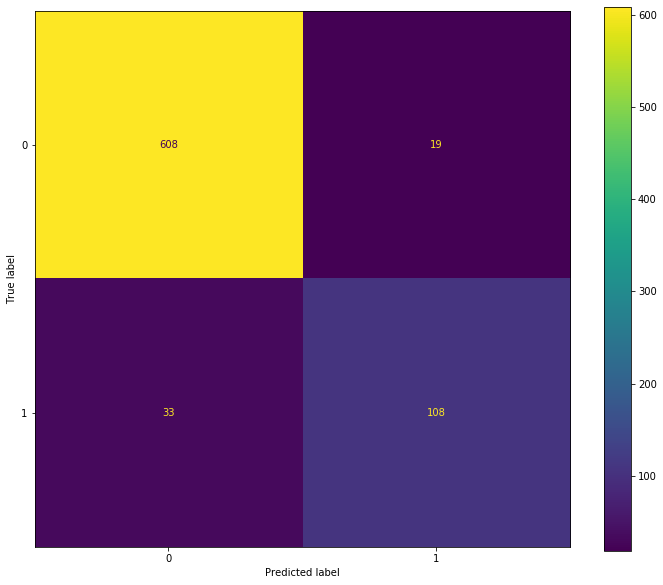

In [57]:
# so far it looks like the best model is LDA
best_so_far = lda_search.best_estimator_

lda_pred_test = best_so_far.predict(X_test)
cm = confusion_matrix(y_test, lda_pred_test)
ConfusionMatrixDisplay(cm).plot()

In [58]:
f1_score(y_test, lda_pred_test)

0.8059701492537313

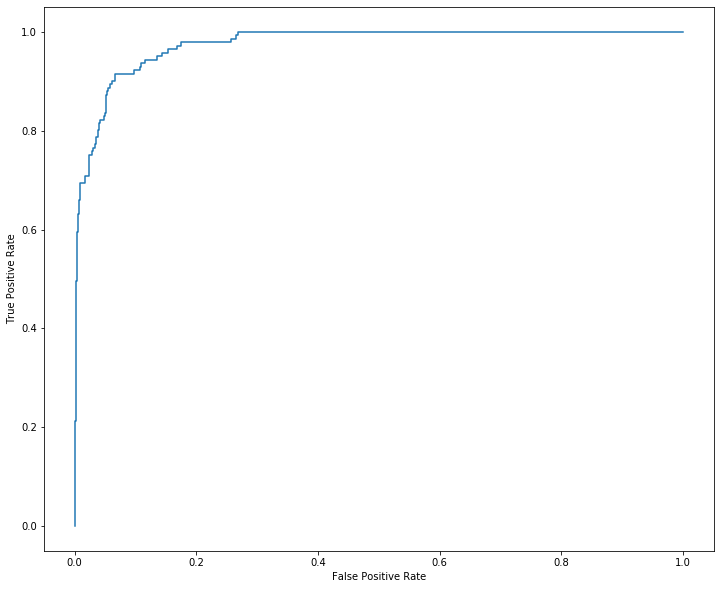

In [59]:
score_test = best_so_far.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, score_test, pos_label=best_so_far.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

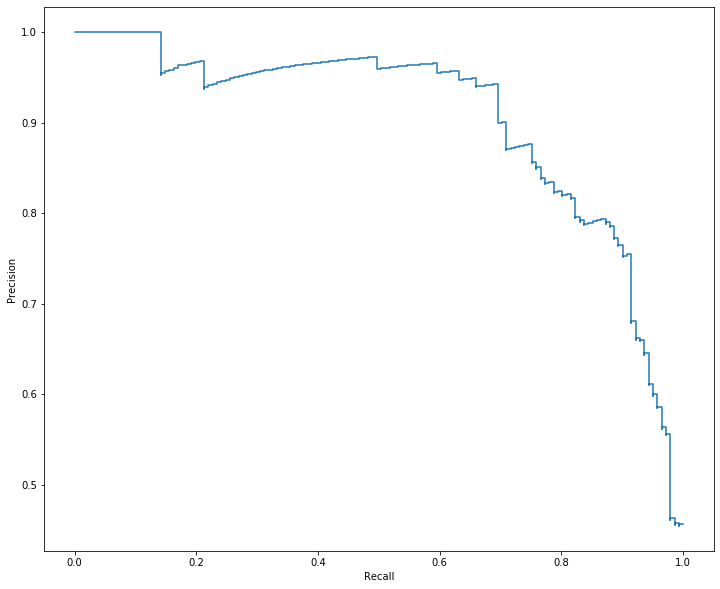

In [60]:
prec, recall, _ = precision_recall_curve(y_test, score_test, pos_label=best_so_far.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()